In [ ]:
from nltk.corpus import stopwords
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as  plt
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
from tensorflow import keras

import tensorflow as tf
#fitting for gpu


config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

df_clean = pd.read_csv("./drive/My Drive/total_data.csv")
#---------------------------------------------------------------------------------------
given_ingredient = list(df_clean.ingredients)[0:192]
#-----------------------------创建评估用词表--------------------------------------------
reference_recipe = list(df_clean.recipes)
reference_meteor = []
references = []
reference_list = reference_recipe[0:192]
for astr in reference_list:
    alist = astr.split(' ')[1:-1]
    reference_meteor.append(' '.join(alist))
    references.append([alist])
clean_summaries = list(df_clean.ingredients)
clean_texts = list(df_clean.recipes)
sp_dataset = tuple(clean_summaries)
en_dataset = tuple(clean_texts)
#将词语式数据转成ID式
def tokenizer(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(
        num_words=None, filters='', split=' ')
    lang_tokenizer.fit_on_texts(lang)#统计词频，生成词表
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')#在句子后面做padding
    return tensor, lang_tokenizer

input_tensor, input_tokenizer = tokenizer(sp_dataset)
output_tensor, output_tokenizer = tokenizer(en_dataset)

def max_length(tensor):
    return max(len(t) for t in tensor)

max_length_input = max_length(input_tensor)
max_length_output = max_length(output_tensor)
print(max_length_input, max_length_output)

from sklearn.model_selection import train_test_split
input_train, input_eval, output_train, output_eval = train_test_split(input_tensor[192:], output_tensor[192:], test_size=0.01, shuffle=False)

batch_size = 64
epochs = 20
dataset = tf.data.Dataset.from_tensor_slices((input_train, output_train))
train_dataset = dataset.repeat(epochs).batch(batch_size, drop_remainder= True)
train_dataset = train_dataset.shuffle(10000)
eval_dataset = tf.data.Dataset.from_tensor_slices((input_eval, output_eval))
eval_dataset = eval_dataset.repeat(epochs).batch(batch_size, drop_remainder= True)

for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x)
    print(y)

embedding_units = 256
units = 256
#input_tokenizer.word_index是个字典
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1
print(input_vocab_size,output_vocab_size)


class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        # 由于用attention，每步输出需要return_sequences = True
        self.gru = keras.layers.GRU(self.encoding_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')

    # hidden是初始化的隐含状态
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))


encoder = Encoder(input_vocab_size, embedding_units, units, batch_size)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder.call(x, sample_hidden)

print('sample_output.shape: ', sample_output.shape)
print('sample_hidden.shape: ', sample_hidden.shape)


class BahdanauAttention(keras.Model):

    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)

    def call(self, decoder_hidden, encoder_outputs):
        # decoder_hidden.shape = (batch_size, units)
        # encoder_outputs.shape = (batch_size, length, units)
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden,
                                                       1)  # decoder_hidden.shape = (batch_size, 1, units)
        # before V:tf.nn.tanh/shape: (batch_size, length, units)
        # after V:(batch_size, length, 1)
        score = self.V(
            tf.nn.tanh(
                self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis)))

        # shape: (batch_size, length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        # context_vector.shape:(batch_size, length, units)
        context_vector = attention_weights * encoder_outputs
        # context_vector.shape:(batch_size, units)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # 在length上求和

        return context_vector, attention_weights


attention_model = BahdanauAttention(units=10)  # units:经过W1之后的units个数，与batch_size, length, units里units不同
attention_results, attention_weights = attention_model.call(sample_hidden, sample_output)

print(attention_results.shape)
print(attention_weights.shape)


class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, decoding_units, batch_size):
        super(Decoder, self).__init__()  # 调用父类（keras.Model）的构造函数
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.GRU(self.decoding_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')

        self.fc = keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.decoding_units)

        # x:当前步输入，hidden:前一步输出

    def call(self, x, hidden, encoding_outputs):
        # context_vector.shape: (bathc_size, units)
        context_vector, attention_weights = self.attention.call(hidden, encoding_outputs)
        # befor embedding:x.shape:(batch_size, 1)
        # after embedding:x.shape:(batch_size, 1, embedding_units)

        x = self.embedding(x)

        combined_x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # output.shape: (batch_size, 1, decoding_units)
        # state.shape: (batch_size, decoding_units)
        output, state = self.gru(combined_x, initial_state=hidden)

        # 从这里通过tf.reshape将output nd array形式改编成tensor形式
        # output.shape: (batch_size, decoding_units)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output.shape: (batch_size, vocab_size)
        output = self.fc(output)

        return context_vector, output, state, attention_weights


decoder = Decoder(output_vocab_size, embedding_units, units, batch_size)

outputs = decoder.call(tf.random.uniform((batch_size, 1)), sample_hidden, sample_output)

context_vector, decoder_output, decoder_hidden, decoder_aw = outputs

print(type(decoder_output))
print(decoder_hidden.shape)
print(decoder_aw.shape)
# print(decoder.trainable_variables+[1,1])

optimizer = keras.optimizers.Adam()

loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


# from_logits直接经过fc的输出没有经过softmax,如果经过softmax就设成False

def loss_function(real, pred):
    # 输出里的padding不应该计算到损失函数中去
    mask = tf.math.logical_not(tf.math.equal(real, 0))  # 是padding时，mask取0
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

W11 = keras.layers.Dense(1)
W22 = keras.layers.Dense(1)
W33 = keras.layers.Dense(1)


# @tf.function#加速cell
# 开了上面的加速就没办法用tensor.numpy()将tensor形式转换为ndarray的形式了

def train_step(inp, targ, encoding_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden = encoder(inp, encoding_hidden)

        inp = inp.numpy()
        # session = tf.compat.v1.Session()
        # inp = session.run(inp)

        decoding_hidden = encoding_hidden

        # eg: <start> I am here <end>
        # 1. <start> -> I
        # 2. I -> am
        # 3. am -> here
        # 4. here -> <end>
        for t in range(0, targ.shape[1] - 1):
            decoding_input = tf.expand_dims(targ[:, t], 1)
            context_vector, predictions, decoding_hidden, decoding_aw = decoder.call(decoding_input, decoding_hidden,
                                                                                     encoding_outputs)

            # 由decoding.call返回的三维decoding_aw
            attention_weights = np.reshape(decoding_aw, (-1, 35))
            adpre = np.zeros((64, 6728))

            for index1, sen in enumerate(inp):
                for index2, word_index in enumerate(sen):
                    # int means only integer can be used as indices
                    adpre[index1][int(word_index)] = attention_weights[index1][index2]
            # tf.nn.sigmoid之前shape应该是64,1
            prob = tf.nn.sigmoid(W11(context_vector) + W22(decoding_hidden) + W33(decoding_input))
            # print(prob.shape)
            adpre = tf.convert_to_tensor(adpre, tf.float32)
            # prob = tf.conver_to_tensor(prob)
            # print(prob)
            # print(adpre)
            new_prediction = (1 - prob) * adpre + prob * predictions
            loss += loss_function(targ[:, t + 1], new_prediction)

    batch_loss = loss / int(targ.shape[0])

    variables = encoder.trainable_variables + decoder.trainable_variables + W11.trainable_variables + W22.trainable_variables + W33.trainable_variables

    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss


def eval_step(inp, targ, encoding_hidden):
    loss = 0

    encoding_outputs, encoding_hidden = encoder(inp, encoding_hidden)
    inp = inp.numpy()
    decoding_hidden = encoding_hidden

    # eg: <start> I am here <end>
    # 1. <start> -> I
    # 2. I -> am
    # 3. am -> here
    # 4. here -> <end>
    for t in range(0, targ.shape[1] - 1):
        decoding_input = tf.expand_dims(targ[:, t], 1)
        context_vector, predictions, decoding_hidden, decoding_aw = decoder.call(decoding_input, decoding_hidden,
                                                                                 encoding_outputs)
        attention_weights = np.reshape(decoding_aw, (-1, 35))
        adpre = np.zeros((64, 6728))
        for index1, sen in enumerate(inp):
            for index2, word_index in enumerate(sen):
                # int means only integer can be used as indices
                adpre[index1][int(word_index)] = attention_weights[index1][index2]
            # tf.nn.sigmoid之前shape应该是64,1
        prob = tf.nn.sigmoid(W11(context_vector) + W22(decoding_hidden) + W33(decoding_input))
        # print(prob.shape)
        adpre = tf.convert_to_tensor(adpre, tf.float32)
        # prob = tf.conver_to_tensor(prob)
        new_prediction = (1 - prob) * adpre + prob * predictions
        loss += loss_function(targ[:, t + 1], new_prediction)

    batch_loss = loss / int(targ.shape[0])
    return batch_loss




35 216
(64, 35)
(64, 216)
tf.Tensor(
[[  1  27 705 ...   0   0   0]
 [  1 244  20 ...   0   0   0]
 [  1  20  12 ...   0   0   0]
 ...
 [  1  83  35 ...   0   0   0]
 [  1 133   6 ...   0   0   0]
 [  1  51 185 ...   0   0   0]], shape=(64, 35), dtype=int32)
tf.Tensor(
[[ 11  24   4 ...   0   0   0]
 [ 11  42  17 ...   0   0   0]
 [ 11  24  48 ...   0   0   0]
 ...
 [ 11 401 178 ...   0   0   0]
 [ 11  42  17 ...   0   0   0]
 [ 11  42   4 ...   0   0   0]], shape=(64, 216), dtype=int32)
3492 6728
sample_output.shape:  (64, 35, 256)
sample_hidden.shape:  (64, 256)
(64, 256)
(64, 35, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 256)
(64, 35, 1)


In [ ]:
checkpoint_dir = './drive/My Drive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
adict = {'training_loss': [], 'validation_loss': []}
alist = []
import time

# epochs = 20
epochs = 20
# steps_per_epoch = len(input_tensor[192:18973]) // batch_size
# steps_per_epoch1 = len(input_tensor[18973:]) // batch_size
steps_per_epoch = len(input_train) // batch_size
steps_per_epoch1 = len(input_eval) // batch_size
for epoch in range(epochs):
    start = time.time()

    encoding_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    total_loss1 = 0
    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        # inp_np = inp.numpy()
        # print(type(inp_np))
        batch_loss = train_step(inp, targ, encoding_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)


    for (batch1, (inp, targ)) in enumerate(eval_dataset.take(steps_per_epoch1)):
        eval_loss = eval_step(inp, targ, encoding_hidden)
        total_loss1 += eval_loss

    print('Epoch {} Loss {:4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Epoch {} Eval_Loss {:4f}'.format(epoch + 1, total_loss1 / steps_per_epoch1))
    print('Time take for 1 epoch {} sec\n'.format(time.time() - start))
    adict['training_loss'].append(round(float(total_loss / steps_per_epoch), 3))
    adict['validation_loss'].append(round(float(total_loss1 / steps_per_epoch1), 3))



Epoch 1 Batch 0 Loss 10.996142
Epoch 1 Batch 100 Loss 7.336029
Epoch 1 Batch 200 Loss 6.854764
Epoch 1 Loss 7.488024
Epoch 1 Eval_Loss 7.456709
Time take for 1 epoch 1173.1606063842773 sec

Epoch 2 Batch 0 Loss 6.920630
Epoch 2 Batch 100 Loss 7.393551
Epoch 2 Batch 200 Loss 6.693661
Epoch 2 Loss 6.676306
Epoch 2 Eval_Loss 6.831205
Time take for 1 epoch 1172.7153244018555 sec

Epoch 3 Batch 0 Loss 6.574397
Epoch 3 Batch 100 Loss 6.106973
Epoch 3 Batch 200 Loss 6.344628
Epoch 3 Loss 6.165952
Epoch 3 Eval_Loss 6.323842
Time take for 1 epoch 1176.0077459812164 sec

Epoch 4 Batch 0 Loss 5.733786
Epoch 4 Batch 100 Loss 5.951343
Epoch 4 Batch 200 Loss 5.488540
Epoch 4 Loss 5.584373
Epoch 4 Eval_Loss 5.818423
Time take for 1 epoch 1179.3079233169556 sec

Epoch 5 Batch 0 Loss 5.260111
Epoch 5 Batch 100 Loss 5.080362
Epoch 5 Batch 200 Loss 4.791881
Epoch 5 Loss 5.103146
Epoch 5 Eval_Loss 5.482355
Time take for 1 epoch 1188.5842835903168 sec

Epoch 6 Batch 0 Loss 5.432190
Epoch 6 Batch 100 Loss 4

In [ ]:
from nltk.corpus import stopwords
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as  plt
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
from tensorflow import keras
import tensorflow as tf
optimizer = keras.optimizers.Adam()
checkpoint_dir = './drive/My Drive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> sugar salt eggs tomatoes <end>
Predicted translation: place the salt and sugar in a large bowl . set aside . in a large bowl , mix together the eggs , and water . pour the mixture over the eggs to cover the bottom of the pan . cover with plastic wrap , and refrigerate for at least 1 hour . <end> 


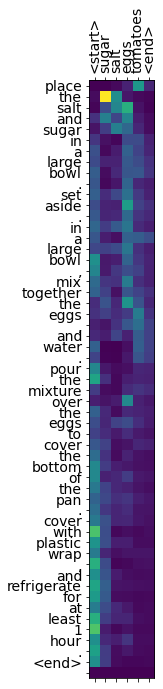

'place the salt and sugar in a large bowl . set aside . in a large bowl , mix together the eggs , and water . pour the mixture over the eggs to cover the bottom of the pan . cover with plastic wrap , and refrigerate for at least 1 hour . <end> '

In [ ]:
#plotting attention map
import matplotlib.ticker as ticker
def evaluate(input_sentence):
    attention_matrix = np.zeros((max_length_output, max_length_input))
    
    
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
    inputs = keras.preprocessing.sequence.pad_sequences(
    [inputs], maxlen=max_length_input, padding='post')
    
    inputs = tf.convert_to_tensor(inputs)
    results = ''
    #encoding_hidden = encoder.initialize_hidden_state()
    encoding_hidden = tf.zeros((1,units))
    
    encoding_outputs, encoding_hidden = encoder(inputs, encoding_hidden)
    decoding_hidden = encoding_hidden
    #eg: <start> I am here <end>
        #1. <start> -> I
        #2. I -> am
        #3. am -> here
        #4. here -> <end>
    #decoding_inpu.shape :(1,1)(batch_size, length)
    decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']],0)
    for t in range(max_length_output):
        #attention_weights.shape: (batch_size, input_length, 1)(1,16,1)
        context_vector, predictions, decoding_hidden, decoding_aw = decoder(decoding_input, decoding_hidden, encoding_outputs)
        
         #-------------------------------------------------------------------------
        attention_weights = np.reshape(decoding_aw, (-1, 35))
        #经历过上一步后attention_weights.shape = 1,35
        adpre = np.zeros((1,6728))
        for index1,sen in enumerate(inputs):
            for index2, word_index in enumerate(sen):
                #int means only integer can be used as indices
                adpre[index1][int(word_index)] = attention_weights[index1][index2]
            #tf.nn.sigmoid之前shape应该是64,1
        prob = tf.nn.sigmoid(W11(context_vector) + W22(decoding_hidden) + W33(decoding_input))
        #print(prob.shape)
        adpre = tf.convert_to_tensor(adpre,tf.float32)
        #prob = tf.conver_to_tensor(prob)
        new_prediction = (1-prob) * adpre + prob * predictions
        #-------------------------------------------------------------------------------
        
        attention_weights = tf.reshape(decoding_aw, (-1,))#length=16的向量
        attention_matrix[t] = attention_weights.numpy()#attention_weights是一个tensor，用numpy（）取出它的值
        #predictions.shape: (batch_size, vocab_size)  (1,4935)
        
        predicted_id = tf.argmax(new_prediction[0]).numpy()
        results += output_tokenizer.index_word[predicted_id] + ' '
        if output_tokenizer.index_word[predicted_id] == '<end>':
            return results, input_sentence, attention_matrix
        
        decoding_input = tf.expand_dims([predicted_id],0)
    return results, input_sentence, attention_matrix

def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(11,11))
    ax = fig.add_subplot(1,1,1)#add a subplot,1,1,1表示子图位置
    ax.matshow(attention_matrix, cmap='viridis')#viridis是一种配色方案
    
    font_dict = {'fontsize': 14}
    ax.set_xticklabels([''] + input_sentence, fontdict=font_dict, rotation = 90)#seq2seq里不需要加空格
    ax.set_yticklabels([''] + predicted_sentence, fontdict=font_dict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

def translate(input_sentence):
    results, input_sentence, attention_matrix = evaluate(input_sentence)
    
    #------------------------
    
    print('Input: %s' % (input_sentence))
    print('Predicted translation: %s' % (results))
    
    attention_matrix = attention_matrix[:len(results.split(' ')), :len(input_sentence.split(' '))]
    
    plot_attention(attention_matrix, input_sentence.split(' '), results.split(' '))
    return results
translate('<start> sugar salt eggs tomatoes <end>')

In [ ]:
#modified evaluate
def evaluate(input_sentence):
    attention_matrix = np.zeros((max_length_output, max_length_input))
    
    
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
    inputs = keras.preprocessing.sequence.pad_sequences(
    [inputs], maxlen=max_length_input, padding='post')
    
    inputs = tf.convert_to_tensor(inputs)
    results = ''
    #encoding_hidden = encoder.initialize_hidden_state()
    encoding_hidden = tf.zeros((1,units))
    
    encoding_outputs, encoding_hidden = encoder(inputs, encoding_hidden)
    decoding_hidden = encoding_hidden
    #eg: <start> I am here <end>
        #1. <start> -> I
        #2. I -> am
        #3. am -> here
        #4. here -> <end>
    #decoding_inpu.shape :(1,1)(batch_size, length)
    decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']],0)
    for t in range(max_length_output):
        #attention_weights.shape: (batch_size, input_length, 1)(1,16,1)
        context_vector, predictions, decoding_hidden, decoding_aw = decoder(decoding_input, decoding_hidden, encoding_outputs)
        
         #-------------------------------------------------------------------------
        attention_weights = np.reshape(decoding_aw, (-1, 35))
        #经历过上一步后attention_weights.shape = 1,35
        adpre = np.zeros((1,6728))
        for index1,sen in enumerate(inputs):
            for index2, word_index in enumerate(sen):
                #int means only integer can be used as indices
                adpre[index1][int(word_index)] = attention_weights[index1][index2]
            #tf.nn.sigmoid之前shape应该是64,1
        prob = tf.nn.sigmoid(W11(context_vector) + W22(decoding_hidden) + W33(decoding_input))
        #print(prob.shape)
        adpre = tf.convert_to_tensor(adpre,tf.float32)
        #prob = tf.conver_to_tensor(prob)
        new_prediction = (1-prob) * adpre + prob * predictions
        #-------------------------------------------------------------------------------
        
        attention_weights = tf.reshape(decoding_aw, (-1,))#length=16的向量
        attention_matrix[t] = attention_weights.numpy()#attention_weights是一个tensor，用numpy（）取出它的值
        #predictions.shape: (batch_size, vocab_size)  (1,4935)
        
        predicted_id = tf.argmax(new_prediction[0]).numpy()
        results += output_tokenizer.index_word[predicted_id] + ' '
        if output_tokenizer.index_word[predicted_id] == '<end>':
            return results, input_sentence, attention_matrix
        
        decoding_input = tf.expand_dims([predicted_id],0)
    return results, input_sentence, attention_matrix

def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)#add a subplot,1,1,1表示子图位置
    ax.matshow(attention_matrix, cmap='viridis')#viridis是一种配色方案
    
    font_dict = {'fontsize': 14}
    ax.set_xticklabels([''] + input_sentence, fontdict=font_dict, rotation = 90)#seq2seq里不需要加空格
    ax.set_yticklabels([''] + predicted_sentence, fontdict=font_dict)
    plt.show()

def translate(input_sentence):
    results, input_sentence, attention_matrix = evaluate(input_sentence)
    
    #------------------------
    
    print('Input: %s' % (input_sentence))
    print('Predicted translation: %s' % (results))
    
    #attention_matrix = attention_matrix[:len(results.split(' ')), :len(input_sentence.split(' '))]
    
    #plot_attention(attention_matrix, input_sentence.split(' '), results.split(' '))
    return results

#----------------------BLEU and Meteor------------------------------
candidates = []
candidates_meteor = []
for sample1 in clean_summaries[0:192]:
    #res = translate(sample1+', ')
    res = translate(sample1)
    candidates_meteor.append(res)
    candidates.append(res.split(' '))

from nltk.translate.bleu_score import corpus_bleu
score = corpus_bleu(references, candidates,weights=(1,0,0,0))
score1 = corpus_bleu(references, candidates,weights=(0.33,0.33,0.33,0))
score2 = corpus_bleu(references, candidates,weights=(0.25,0.25,0.25,0.25))
print(score,score1,score2)

Input: <start> skinless boneless chicken breast butter condensed cream chicken soup onion finely diced refrigerated biscuit dough torn pieces <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . melt butter in a large skillet over medium high heat . add chicken and cook until browned on all sides , about 5 minutes . remove from heat and cool completely . in a small bowl , combine the chicken , cream of celery , and chicken . mix well . pour into a 9x13 inch baking dish . bake in the preheated oven until the chicken is no longer pink in the center , about 45 minutes . <end> 
Input: <start> condensed cream mushroom soup package dry onion soup mix water pot roast <end>
Predicted translation: in a large bowl , combine the soup , soup mix , and dry onion soup mix . pour over the roast , and pour the soup over the top of the roast . cover , and refrigerate overnight . preheat an outdoor grill for high heat . place the roast on the preheated grill , and cook for 1 hour .

In [ ]:
def calculate_given_item(given_ingredient, generated_recipe):
    '''
    given_ingredient = ['egg tomatoes','chicken']
    splitted_ingredient = [['egg','tomatoes'],['chicken']]
    generated_recipe = [['use','egg'],['use','chicken'],...]
    '''

    total_score = 0
    extra_score = 0
    splitted_ingredient = []
    for bstr in given_ingredient:
        splitted_ingredient.append(bstr.split(' '))

    for index, each_sample in enumerate(splitted_ingredient):
        # count1 covered items
        # count2 extra items
        count1 = 0
        count2 = 0
        for each_word in each_sample:
            # generated_recipe就是下面的candidates=[['use','egg'],['use','chicken'],...]
            if each_word in generated_recipe[index]:
                count1 += 1
            else:
                count2 += 1
        extra_score += count2 / len(each_sample)
        total_score += count1 / len(each_sample)
    # -------------------------------------------------------------------------
    for index, each_recipe in enumerate(generated_recipe):
        # count1 covered items
        # count2 extra items
        extra_item = 0
        for each_word in each_recipe:
            # generated_recipe就是下面的candidates=[['use','egg'],['use','chicken'],...]
            if each_word in input_tokenizer.word_index and each_word not in splitted_ingredient[index]:
                extra_item += 1

    # --------------------------------------------------------------------------

    total_score = total_score / len(given_ingredient)

    return total_score, extra_item

cover_item, extra_item = calculate_given_item(given_ingredient, candidates)
print(cover_item,extra_item)

0.43534717108539717 17
['place the chicken , butter , soup , and onion in a slow cooker , and fill with enough water to cover . cover , and cook for 5 to 6 hours on high . about 30 minutes before serving , place the torn biscuit dough in the slow cooker . cook until the dough is no longer raw in the center .', 'in a slow cooker , mix cream of mushroom soup , dry onion soup mix and water . place pot roast in slow cooker and coat with soup mixture . cook on high setting for 3 to 4 hours , or on low setting for 8 to 9 hours .', 'preheat oven to 350 degrees f 175 degrees c . lightly grease a 9x5 inch loaf pan . in a large bowl , combine flour , baking soda and salt . in a separate bowl , cream together butter and brown sugar . stir in eggs and mashed bananas until well blended . stir banana mixture into flour mixture stir just to moisten . pour batter into prepared loaf pan . bake in preheated oven for 60 to 65 minutes , until a toothpick inserted into center of the loaf comes out clean . 

In [ ]:
print(reference_meteor)

['place the chicken , butter , soup , and onion in a slow cooker , and fill with enough water to cover . cover , and cook for 5 to 6 hours on high . about 30 minutes before serving , place the torn biscuit dough in the slow cooker . cook until the dough is no longer raw in the center .', 'in a slow cooker , mix cream of mushroom soup , dry onion soup mix and water . place pot roast in slow cooker and coat with soup mixture . cook on high setting for 3 to 4 hours , or on low setting for 8 to 9 hours .', 'preheat oven to 350 degrees f 175 degrees c . lightly grease a 9x5 inch loaf pan . in a large bowl , combine flour , baking soda and salt . in a separate bowl , cream together butter and brown sugar . stir in eggs and mashed bananas until well blended . stir banana mixture into flour mixture stir just to moisten . pour batter into prepared loaf pan . bake in preheated oven for 60 to 65 minutes , until a toothpick inserted into center of the loaf comes out clean . let bread cool in pan f

In [ ]:
print(candidates_meteor)

['preheat oven to 350 degrees f 175 degrees c . melt butter in a large skillet over medium high heat . add chicken and cook until browned on all sides , about 5 minutes . remove from heat and cool completely . in a small bowl , combine the chicken , cream of celery , and chicken . mix well . pour into a 9x13 inch baking dish . bake in the preheated oven until the chicken is no longer pink in the center , about 45 minutes . <end> ', 'in a large bowl , combine the soup , soup mix , and dry onion soup mix . pour over the roast , and pour the soup over the top of the roast . cover , and refrigerate overnight . preheat an outdoor grill for high heat . place the roast on the preheated grill , and cook for 1 hour . remove the foil and discard the marinade . cook for another 10 to 15 minutes , or until the meat is tender and the juices run clear . <end> ', 'preheat oven to 350 degrees f 175 degrees c . grease a 9x13 inch baking pan . in a large bowl , mix flour , baking soda , salt , and brown